In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import random_statevector

In [2]:
def even_block():
    #set of 4 initial Rz gates and then a combination of Cz gates (two-qubit gate)
    pass

def odd_block(): 
    
    #set of 4 Rx gates applied to each qubit
    pass
    
def layer_block():
    
    #an even block + odd block -> one layer
    pass

In [3]:
#qiskit even block
def even_block(qc):
    
    for i in range(4):
        qc.rz(np.pi/2,i) #this must be a parametrized circuit 4 four different angles, e.g theta[i]
    
    tuples = [(i,j) for i in range(4) for j in range(4) if i < j]

    for tup in tuples:
        qc.cz(tup[0], tup[1])

In [4]:
#qiskit  odd block
def odd_block(qc):
    
    for i in range(4):
        qc.rx(np.pi/2, i)

In [5]:
def layer(qc):
    
    odd_block(qc)
    even_block(qc)
    qc.barrier()

In [6]:
def built_circuit(number_layers):
    
    qc = QuantumCircuit(4)
    for i in range(number_layers):
        layer(qc)
    return qc

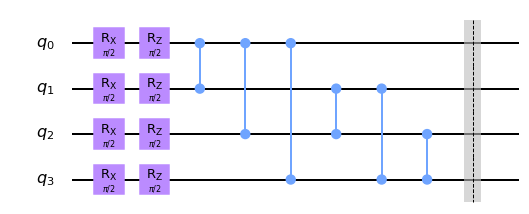

In [7]:
qc = built_circuit(1)

qc.draw(output='mpl')

In [8]:
random_statevector(2, seed = 42)

Statevector([ 0.30719863-0.37807185j, -0.28356911-0.82600196j],
            dims=(2,))

## Simple example - Optimize the circuit for creating a Bell state

In [9]:
#trivial solution
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.h(0) # Put qubit a into state |+>
qc.cx(0,1) # CNOT with a as control and b as target
qc.measure(0,0)
qc.measure(1,1)
qc.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

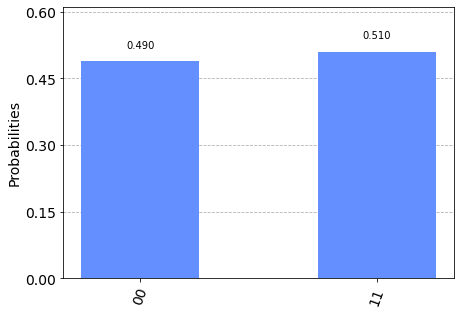

In [10]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [11]:
dev = qml.device('default.qubit', wires = 2)
qml.QubitStateVector(np.array([]), wires = 1)

QubitStateVector(tensor([], dtype=float64, requires_grad=True), wires=[1])

In [12]:
@qml.qnode(dev)
def circuit(params):
    A = np.array([[ 0.5, 0.5],
           [ 0.5,  0.5]])
    qml.U3(params[0], params[1], params[2], wires = 0)
    
    return qml.expval(qml.Hermitian(A, wires = 0))

In [13]:
params = [np.pi*0.5, 0, 0.3]
a = circuit(params)
a

0.9999999999999996

In [14]:
def cost(x):
    
    return (1.0 - circuit(x))

In [15]:
init_params = np.array([0.7, 0, 0.3])
cost(init_params)

0.17789115638115482

In [16]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [17]:
for i in range(steps):
    
    params = opt.step(cost, params)
    
print(params)

[1.57079633 0.         0.3       ]


In [18]:
cost(params)

4.440892098500626e-16

In [19]:
Z = np.random.random(2) + np.random.random(2) * 1j
Z

tensor([0.12995812+0.64492225j, 0.84720237+0.2679809j ], requires_grad=True)

In [20]:
def norm_vect(vect):
    #define the norm of a complex vector here
    pass

In [21]:
print(Z[0])

(0.12995812306912757+0.6449222509931533j)


In [22]:
#the main idea here is to define the observable 

$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

In [23]:
target_distr = np.random.rand(2)
target_distr /= sum(target_distr)

In [24]:
target_distr

tensor([0.43271895, 0.56728105], requires_grad=True)

In [25]:
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

In [26]:
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

In [27]:
from qiskit import Aer, execute
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.absolute(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

In [28]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.51653026 0.48346974]
Obtained Distribution: [0.5113, 0.4887]
Output Error (Manhattan Distance): 0.005939479237933087
Parameters Found: [1.54455682 0.28462694 0.44771819]


In [29]:
z = 3-2j
np.absolute(z)

3.605551275463989

In [30]:
np.sqrt(13)

3.605551275463989